## Replication of the European Commission Debt Sustainability Methodology

This notebook features an updated version of the methodology introduced in "A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal" by Zsolt Darvas, Lennard Welslau, and Jeromin Zettelmeyer (2023). For details on the methodology see Annex II, "Methodology and code for implementing the European Commission´s DSA in the context of the economic governance review".

Note that for the analysis to run, data on growth, ageing costs, property income, interest rate and inflation expectations, as well as institutional debt have to be added to "../data/InputData/deterministic_model_data.xlsx". These data have been sourced directly from the European Commission, the ESM, and Bloomberg, and we have no permission to share them publicly.

For comments and suggestions please contact lennard.welslau[at]bruegel[dot]org.

Last update: 21 December 2023

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_style('whitegrid')

# Import DSA model class and stochastic subclass
from DsaModelClass import DsaModel
from StochasticDsaModelClass import StochasticDsaModel

# Import functions for analysis
from dsa_functions import *

# Set autoreleoad
%load_ext autoreload
%autoreload 2

## Tutorial
This section introduces some of the functionalities of the DsaModel class and the StochasticDsaModel class.

### Initializing the DSA model and projecting the debt ratio

Initialize model with country ISO code and adjustment period length. For deterministic projections the parent class "DsaModel" can be used, although I recommend always calling the StochasticDsaModel class to have access to all functionalities.

In [3]:
bel_dsa = DsaModel(country='BEL', adjustment_period=4)

Model functions (methods) and variables (attributes) can be inspected by typing the class name, followed by the attribute name. \
Explore the DsaModelClass and the StochasticDsaModelClass python files to see which attributes and methods exist.

In [6]:
bel_dsa.ageing_cost

array([24.41146, 24.56619, 24.7434 , 24.75704, 25.01473, 25.19209,
       25.35499, 25.51885, 25.5575 , 25.72   , 25.84949, 25.99172,
       26.10518, 26.29145, 26.42218, 26.58337, 26.69289, 26.84103,
       26.92466, 27.0571 , 27.12789, 27.25907, 27.33299, 27.46982,
       27.54733, 27.6748 , 27.74077, 27.86299, 27.91755, 28.02501,
       28.06556, 28.15976])

We can project the debt ratio forward, assuming linear adjustment to a structural primary balance target using the "project" method. \
To project the model under specific scenario assumptions, pass the scenario name as a string. Deterministic scenarios are "main_adjustment", "adverse_r_g", "financial_stress", and "lower_spb".

In [7]:
bel_dsa.project(spb_target=1.6, scenario='financial_stress')

For non-linear adjustment paths, for example due to an Excessive Deficit Procedure, we can specify initial and intermediate adjustment periods. \
All adjustment steps are saved in the "adjustment_steps" attribute. \
Instead of specifying initial adjustment period manually, we could call the "calculate_edp" method, which finds the number of periods in which, given the current SPB target, the minimum adjustment of 0.5% under the EDP is binding. The resulting length of the initial adjustment period is updated automatically. In cases where the entire adjustment period is needed to reach the 3% deficit targets, the adjustment step size is increased.

In [8]:
bel_dsa.project(spb_target=0.6, 
                initial_adjustment_period=2,
                initial_adjustment_step=0.5,
                intermediate_adjustment_period=0,
                intermediate_adjustment_step=0,
                scenario='main_adjustment')

In [9]:
bel_dsa.adjustment_steps

array([0.5   , 0.5   , 1.0041, 1.0041])

We can show the resulting debt ratio and primary balance path using the "df" method. \
The "df" method takes strings of the model variables or a dictionary with model variables and desired column names as input argument and returns a pandas dataframe. If the method is called without specified variables, it returns a dataframe with the structural primary balance, the overall balance, and the debt ratio. 

In [10]:
bel_dsa.df().iloc[1:7]

spb_bca     ob       d
t y                           
1 2023   -2.811 -4.475 106.058
2 2024   -2.408 -4.739 106.070
3 2025   -1.908 -4.699 107.047
4 2026   -1.408 -4.541 107.815
5 2027   -0.404 -4.021 108.404
6 2028    0.600 -3.389 108.282

If the df method is called with parameter "all" set to "True", a preset list of variables will be included. The variables are listed below.

In [11]:
bel_dsa.df(all=True).columns

Index(['spb_bca', 'spb', 'ob', 'd', 'rg', 'rg_pot', 'ng', 'output_gap', 'pi',
       'rgdp_pot', 'rgdp', 'ngdp', 'i_st', 'i_lt', 'iir_lt', 'iir', 'sf',
       'ageing_cost', 'ageing_component', 'cyclical_component', 'pb',
       'pb_cyclical_adj', 'pb_cyclical_ageing_adj', 'D', 'D_lt_inst', 'D_st',
       'D_lt', 'amortization', 'amortization_lt', 'amortization_lt_inst'],
      dtype='object')

### Deterministic Optimization

The "find_spb_deterministic" optimizes for a structural primary balance at the end of the adjustment period that meets the specified criterion. Additional parameters, like initial adjustment periods, that have been specified in the initial projection as given.\
The criterion can be any of 'main_adjustment', 'lower_spb', 'financial_stress', 'adverse_r_g', 'deficit_reduction', or 'debt_safeguard'. \
Note that the debt_safeguard is applied from the end of the Excessive Deficit Procedure. Because the end of the EDP may vary with the size of annual adjustments, the debt safeguard may produce a different target when applied by itself. In our analysis, we therefore apply the debt safeguard conditional on the toughest scenario path.

In [12]:
bel_dsa.find_spb_deterministic(criterion='adverse_r_g')

2.399899999999824

The model projections are updated automatically to the optimal SPB target and we can plot the resulting debt ratio projection, for example by using the "df" method and pandas' built-in plotting function.\
Here we plot the ageing-cost adjusted structural primary balance, as well as the structural primary balance that includes ageing costs, the overall balance, and the debt ratio.

<Axes: title={'center': 'Belgium: Debt ratio and balance'}, xlabel='(t, Year)'>

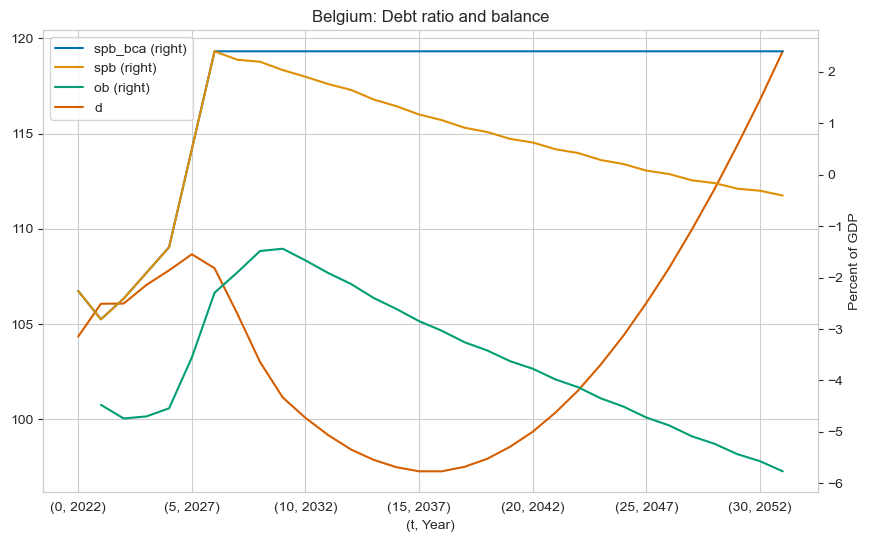

In [18]:
bel_dsa.df('spb_bca', 'spb',  'ob', 'd').plot(
    title='Belgium: Debt ratio and balance', 
    secondary_y=['spb', 'spb_bca', 'ob'], 
    ylabel='Percent of GDP', 
    xlabel='(t, Year)', 
    legend=True, 
    figsize=(10, 6))

### Stochastic Optimization

The StochasticDsaModel class is a subclass of the DsaModel and inherits all its functionalities. It is initiated analogously.

In [19]:
esp_sdsa = StochasticDsaModel(country='ESP', adjustment_period=7)

After projecting the debt path, the "simulate" method simulates N projections based on shocks to growth, interest rate, exchange rate, and primary balance.

In [20]:
esp_sdsa.project()
esp_sdsa.simulate(N=1000000)

The "fanchart" method plots the percentiles of the simulated distribution of the debt ratio. If the save_df option is specified, we can access the underlying percentile data as new model attribute. The period parameter determines the number of projection periods. The Commission methodology uses 5.

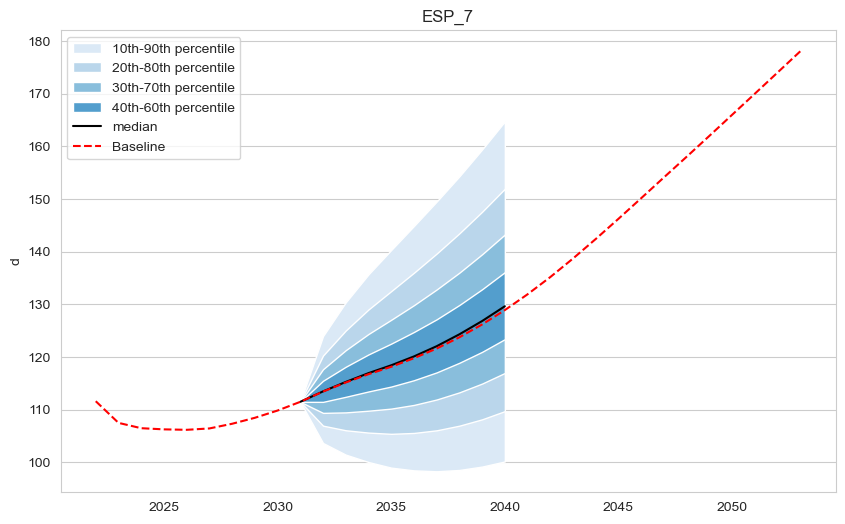

In [21]:
esp_sdsa.fanchart(variable='d', periods=10, save_df=True)

In [22]:
esp_sdsa.df_fanchart.dropna()

year  baseline     p10     p20     p30     p40     p50     p60     p70  \
9   2031   111.503 111.503 111.503 111.503 111.503 111.503 111.503 111.503   
10  2032   113.447 103.679 106.975 109.402 111.495 113.485 115.499 117.691   
11  2033   115.173 101.474 106.099 109.496 112.456 115.278 118.161 121.310   
12  2034   116.749 100.070 105.659 109.814 113.469 116.950 120.499 124.382   
13  2035   118.158  99.004 105.424 110.213 114.402 118.439 122.556 127.083   
14  2036   119.789  98.485 105.590 110.911 115.605 120.122 124.767 129.855   
15  2037   121.621  98.313 106.091 111.943 117.091 122.063 127.170 132.836   
16  2038   123.759  98.561 106.972 113.299 118.918 124.322 129.895 136.030   
17  2039   126.193  99.208 108.179 114.969 120.994 126.842 132.881 139.525   
18  2040   128.920 100.179 109.734 116.982 123.406 129.650 136.129 143.282   

       p80     p90  
9  111.503 111.503  
10 120.290 123.996  
11 125.046 130.404  
12 129.037 135.716  
13 132.525 140.342  
14 136.017 144.905  
15 139.655 149.541  
16 143.502 154.336  
17 147.602 159.433  
18 151.976 164.772

The "find_spb_stochastic" method optimizes for the primary balance path that ensures no more than 30% of simulated debt ratio paths are increasing.

In [23]:
esp_sdsa.find_spb_stochastic(prob_target=0.3)

2.2327045487259434

### Integrated optimization

To quickly calculate all scenarios and detmerine which is binding, we can call the "find_spb_binding" method. Note that this method is only available after initalizing a stochastic model. \
The method determines optimal SPB targets for all deterministic and stochastic DSA criteria, as well as for the 3% deficit criteria. If no spcified differently, the method then checks whether the EDP or either of the two safeguards, the debt and the deficit resilience safeguard, are violated and corrects the binding SPB target accordingly.

In [24]:
esp_sdsa.find_spb_binding(save_df=True, edp=True, debt_safeguard=True, deficit_resilience=True)


________________________ Optimizing ESP 7-year ________________________
SPB*: 2.426699999999817 (adverse_r_g)
EDP not binding
SPB* after binding debt safeguard: 2.972599999999796
Deficit resilience safeguard not binding during adjustment period
Deficit resilience safeguard not binding after adjustment period


'Binding SPB target: 2.9725999999997956 (debt_safeguard)'

The "find_spb_binding" method saves a dictionaries with the binding targets and timeseries for all scenarios. In addition, it saves the projection parameters of the binding scenario for quick replication.

In [25]:
esp_sdsa.spb_target_dict

{'main_adjustment': 1.7115999999998333,
 'lower_spb': 2.1885999999998256,
 'financial_stress': 1.7720999999998333,
 'adverse_r_g': 2.4266999999998164,
 'deficit_reduction': 1.955799999999833,
 'stochastic': 2.214977097267584,
 'debt_safeguard': 2.972599999999796,
 'post_adjustment': 1.9372999999997962,
 'binding': 2.9725999999997956}

In [26]:
esp_sdsa.df_dict['binding'].head()

spb_bca    spb     ob       d    rg  rg_pot     ng  output_gap    pi  \
t y                                                                            
0 2022   -2.329 -2.329    NaN 111.618 5.452   1.192 10.152       0.042 4.142   
1 2023   -2.073 -2.073 -3.922 107.507 2.365   1.672  7.744       0.724 5.255   
2 2024   -0.981 -0.981 -3.153 106.493 1.661   1.827  5.082       0.559 3.366   
3 2025   -0.416 -0.416 -2.852 106.408 1.616   2.000  3.632       0.181 1.983   
4 2026    0.149  0.149 -2.830 105.909 1.162   1.696  3.233      -0.345 2.047   

        rgdp_pot  ...     pb  pb_cyclical_adj  pb_cyclical_ageing_adj  \
t y               ...                                                   
0 2022 1,192.450  ... -2.371              NaN                     NaN   
1 2023 1,212.393  ... -1.639              NaN                     NaN   
2 2024 1,234.538  ... -0.647              NaN                     NaN   
3 2025 1,259.231  ... -0.310              NaN                     NaN   
4 2026 1,280.585  ... -0.061              NaN                     NaN   

               D  D_lt_inst    D_st      D_lt  amortization  amortization_lt  \
t y                                                                            
0 2022 1,502.804     40.157  76.430 1,426.374           NaN              NaN   
1 2023 1,557.691     36.515 100.884 1,456.808       214.900          138.470   
2 2024 1,621.457     28.297 105.013 1,516.444       245.845          144.962   
3 2025 1,679.038     19.146 108.743 1,570.296       255.506          150.493   
4 2026 1,725.184     10.928 111.731 1,613.453       262.287          153.545   

        amortization_lt_inst  
t y                           
0 2022                 0.000  
1 2023                 3.643  
2 2024                 8.218  
3 2025                 9.150  
4 2026                 8.218  

[5 rows x 30 columns]

In [27]:
esp_sdsa.binding_parameter_dict

{'binding_spb_target': 2.972599999999796,
 'initial_adjustment_period': 0,
 'initial_adjustment_step': 0.5,
 'intermediate_adjustment_period': 0,
 'intermediate_adjustment_step': 0,
 'deficit_resilience_periods': array([False, False, False, False, False, False, False]),
 'deficit_resilience_step': 0.25,
 'post_adjustment_periods': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False])}

The "find_deficit_prob" method builds on the stochastic model to calculate the probabilites of an excessive deficit in each year of the adjustment period. \
We can either call it directly by specifying an adjustment path or call it after we have optimized the path as above.

Text(0.5, 1.0, 'Spain: Probability of deficit during 7-year adjustment')

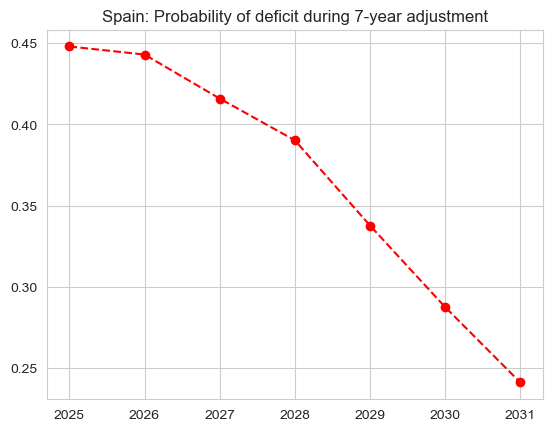

In [28]:
prob_deficit = esp_sdsa.find_deficit_prob()
plt.plot(np.arange(2025, 2032), prob_deficit, marker='o', linestyle='--', color='red')
plt.title('Spain: Probability of deficit during 7-year adjustment')

## Analysis

### Set parameters and functions

In [27]:
# List of EU codes and countries for loop and chart titles
country_code_dict = {
    'AUT': 'Austria',
    'BEL': 'Belgium',
    'CYP': 'Cyprus',
    'CZE': 'Czech Republic',
    'DEU': 'Germany',
    'DNK': 'Denmark',
    'ESP': 'Spain',
    'EST': 'Estonia',
    'FIN': 'Finland',
    'FRA': 'France',
    'GRC': 'Greece',
    'HRV': 'Croatia',
    'HUN': 'Hungary',
    'IRL': 'Ireland',
    'ITA': 'Italy',
    'NLD': 'Netherlands',
    'POL': 'Poland',
    'PRT': 'Portugal',
    'ROU': 'Romania',
    'SVK': 'Slovakia',
    'SVN': 'Slovenia',
    'SWE': 'Sweden',
    'BGR': 'Bulgaria',
    'MLT': 'Malta',
    'LUX': 'Luxembourg',
    'LTU': 'Lithuania',
    'LVA': 'Latvia'
    }
country_codes = list(country_code_dict.keys())

In [28]:
# Initialize results dictionary
results_dict = {}
for country in country_codes:
    results_dict[country] = {}
    for adjustment_period in [4, 7]:
        results_dict[country][adjustment_period] = {}

In [29]:
# Set output path and create folders if they don't exist
today = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
if not os.path.exists(f'../output/{today}'):
    os.makedirs(f'../output/{today}')
if not os.path.exists(f'../output/{today}/fancharts'):
    os.makedirs(f'../output/{today}/fancharts') 
if not os.path.exists(f'../output/{today}/results_charts'):
    os.makedirs(f'../output/{today}/results_charts')       
output_path = f'../output/{today}'

Instead of starting a new results_dict, we can also read in an existing one from the pickle in the output folder 


In [30]:
# today = '2023-12-21_16-00'
# output_path = output_path = f'../output/{today}'
# results_dict = pd.read_pickle(f'{output_path}/dsa_results_dict_{today}.pkl')

In [39]:
# Call functions to run DSA and save results
run_dsa(country_codes=country_codes, results_dict=results_dict, output_path=output_path, today=today)
save_results(results_dict=results_dict, output_path=output_path, today=today)


--> 1 of 27, estimated remaining time: 0.0 minutes

________________________ Optimizing AUT 4-year ________________________
SPB*: 1.1163999999998322 (adverse_r_g)
EDP not binding
Debt safeguard not binding
Deficit resilience safeguard not binding during adjustment period
SPB post-adjustment: 0.40375999999983314, Post adjustment periods: [2033]

________________________ Optimizing AUT 7-year ________________________
SPB*: 1.191088136726662 (stochastic)
EDP not binding
Debt safeguard not binding
Deficit resilience safeguard not binding during adjustment period
Deficit resilience safeguard not binding after adjustment period

--> 2 of 27, estimated remaining time: 8.2 minutes

________________________ Optimizing BEL 4-year ________________________
SPB*: 2.3657999999998163 (adverse_r_g)
EDP already satisfied, deficit below 3% in period 3
Deficit resilience safeguard not binding during adjustment period
SPB post-adjustment: 1.827899999999818, Post adjustment periods: [2035 2038]

_________

### Plot binding scenario charts

Error: CYP_4
Error: CYP_7
Error: GRC_4
Error: GRC_7
Error: HRV_4
Error: HRV_7
Error: ITA_4
Error: ITA_7
Error: BGR_4
Error: BGR_7


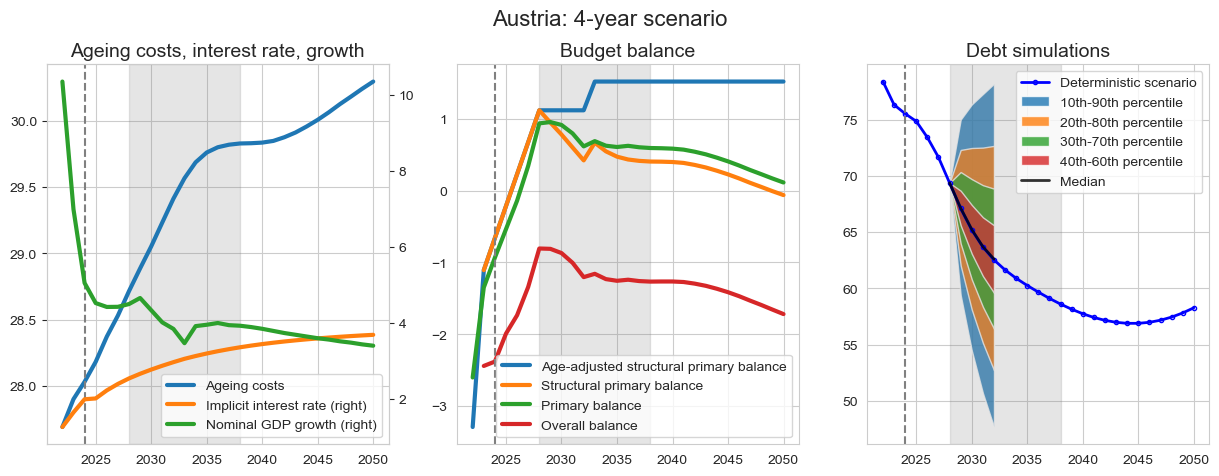

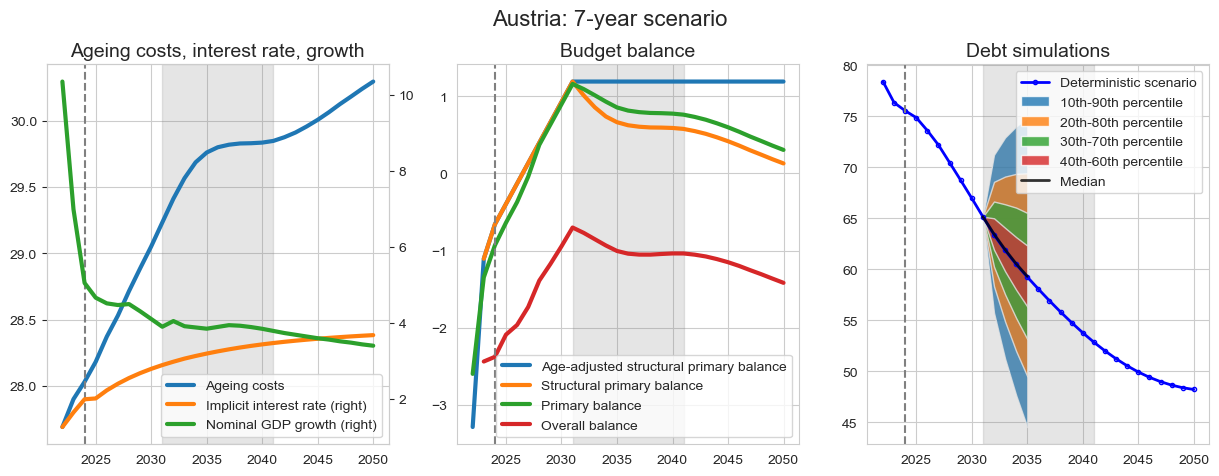

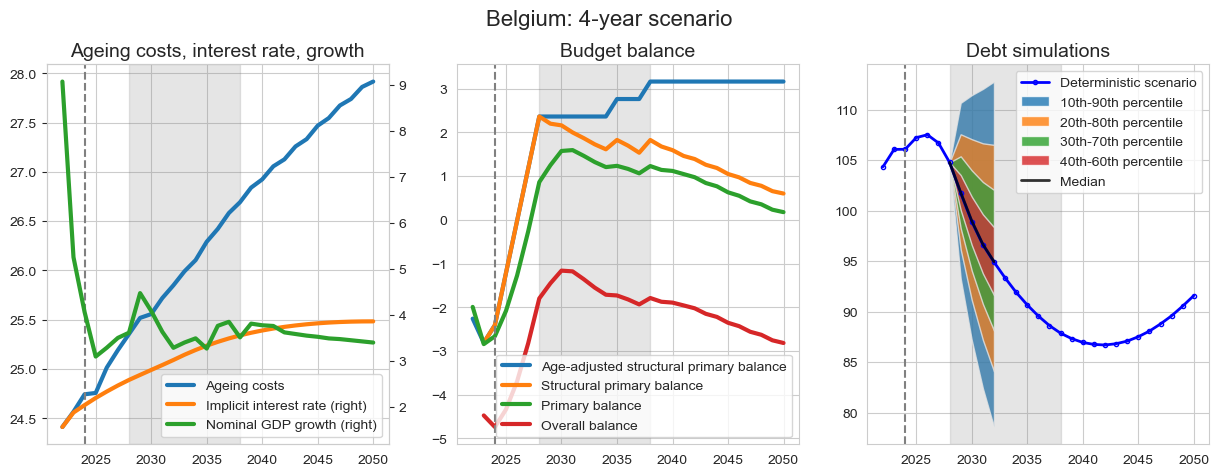

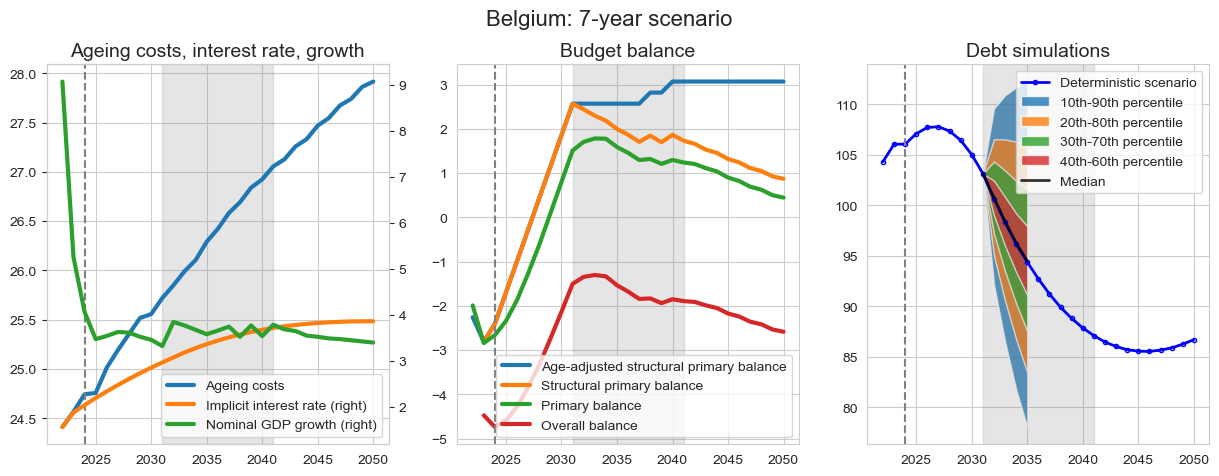

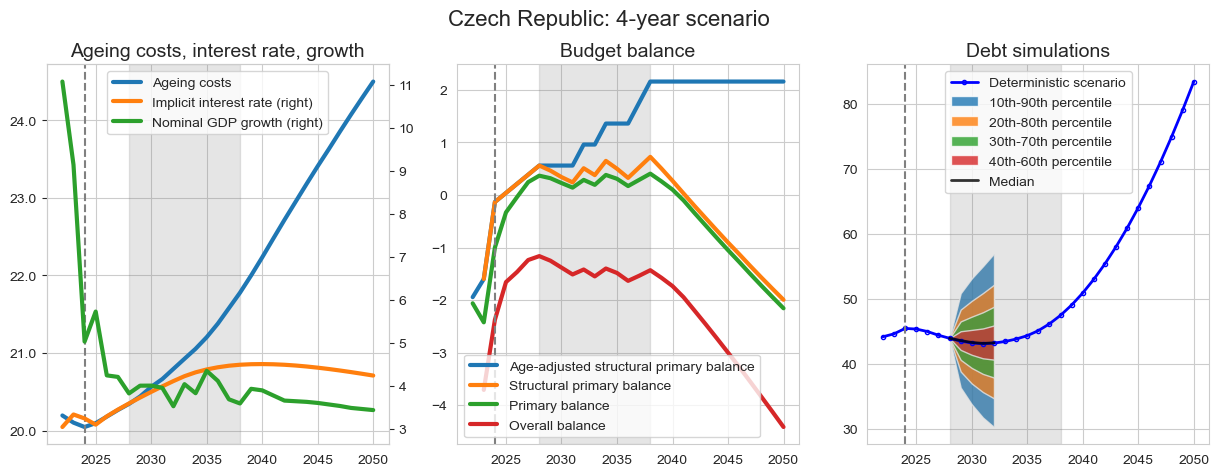

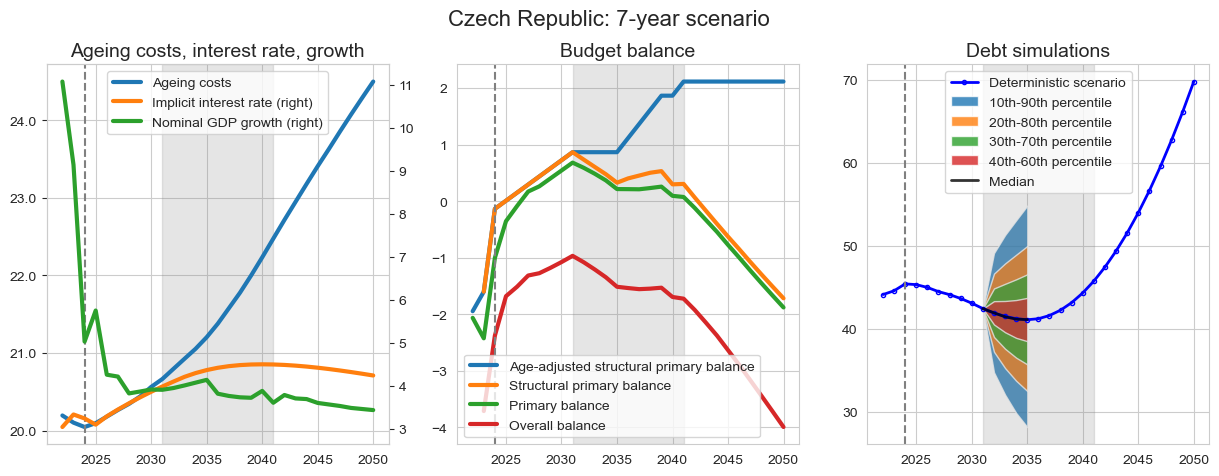

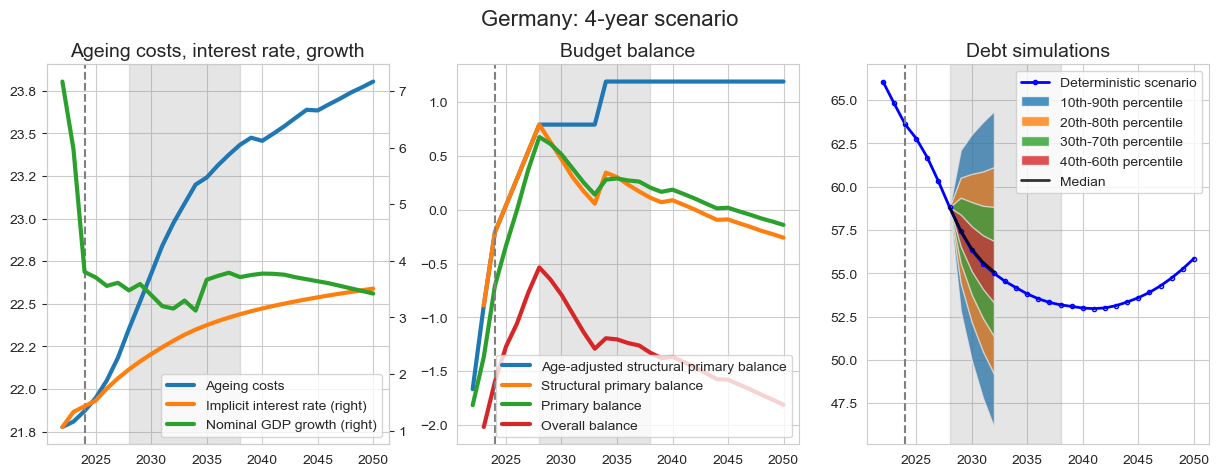

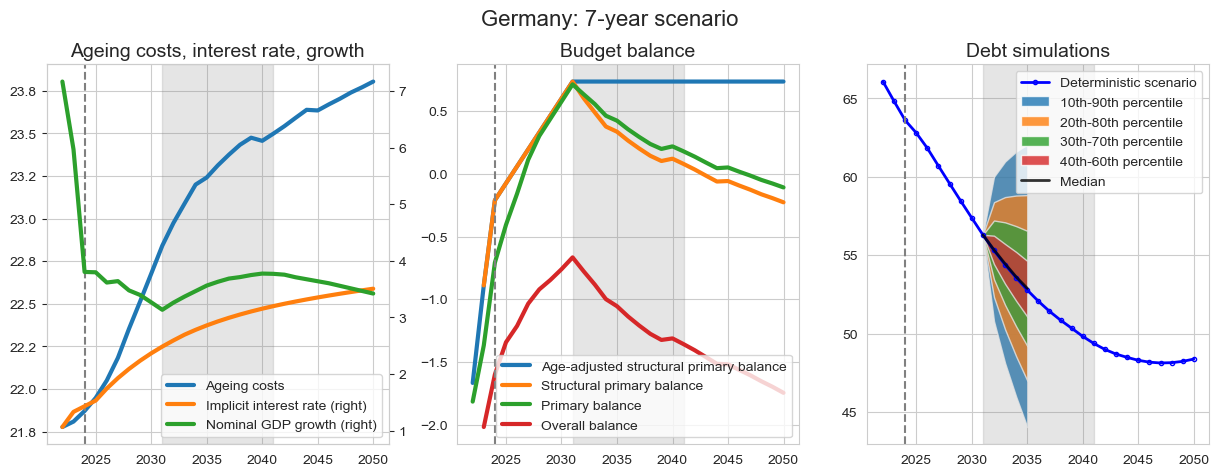

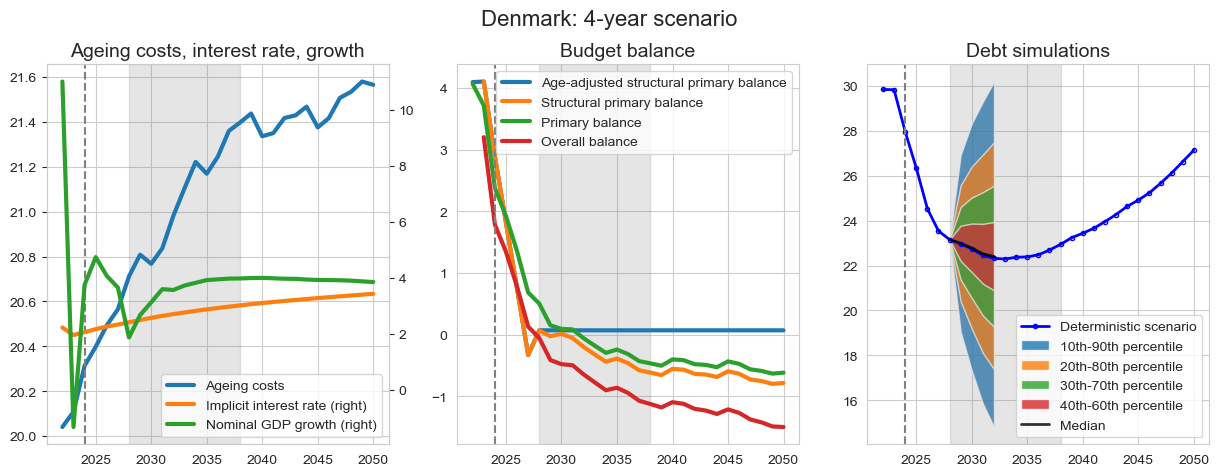

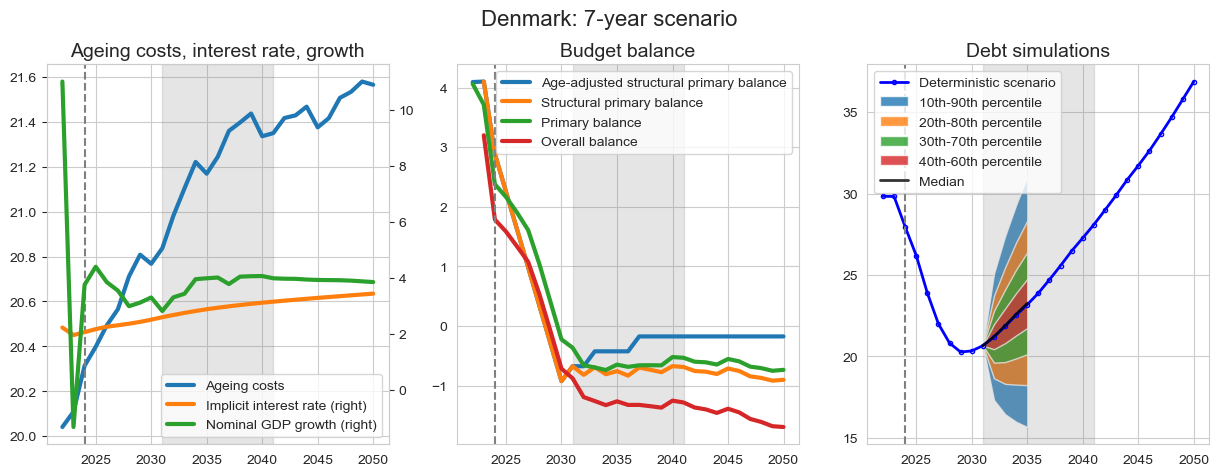

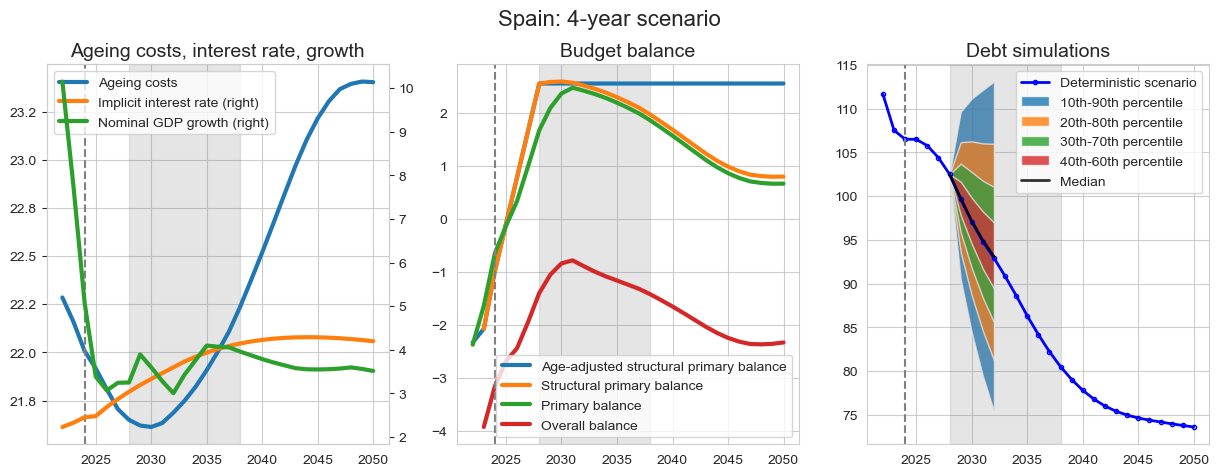

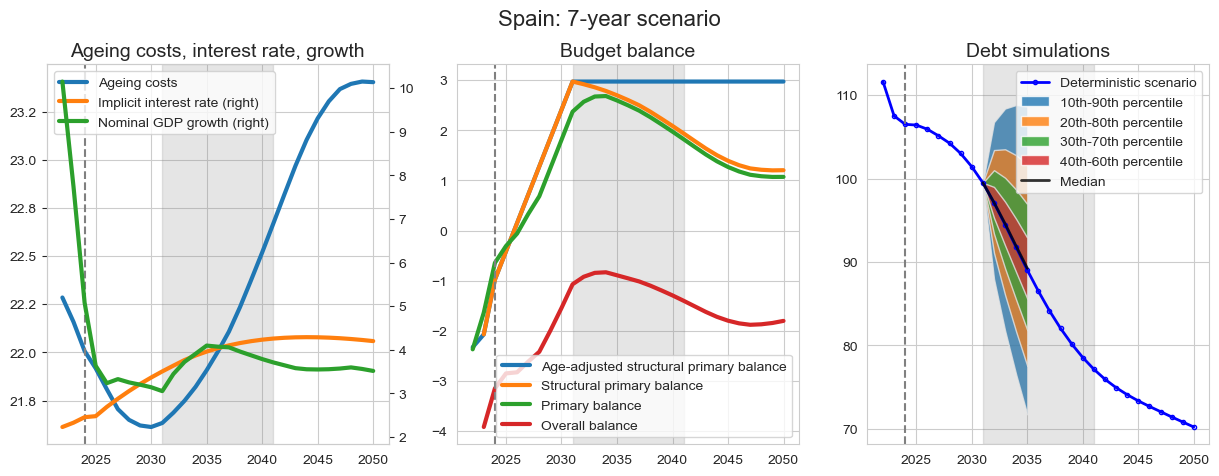

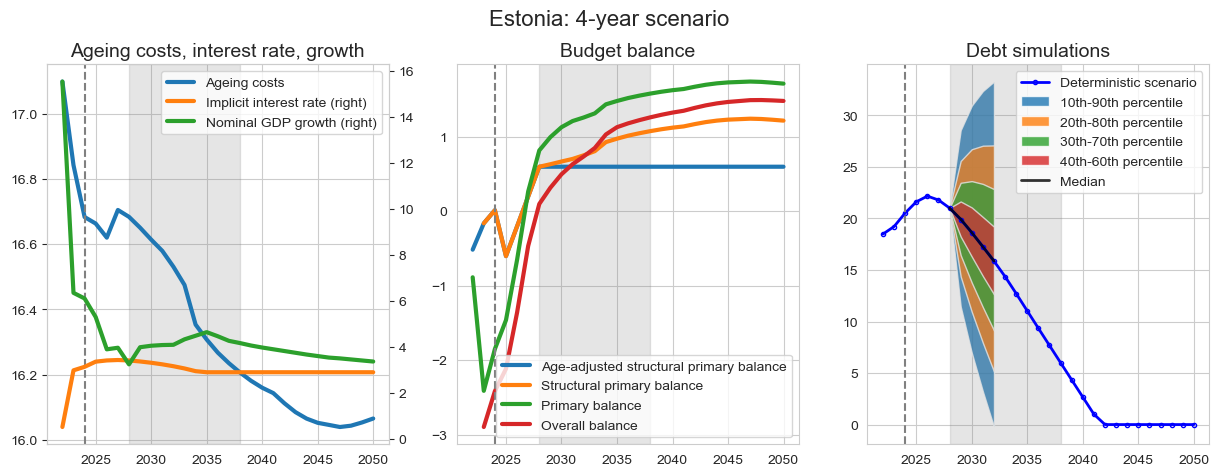

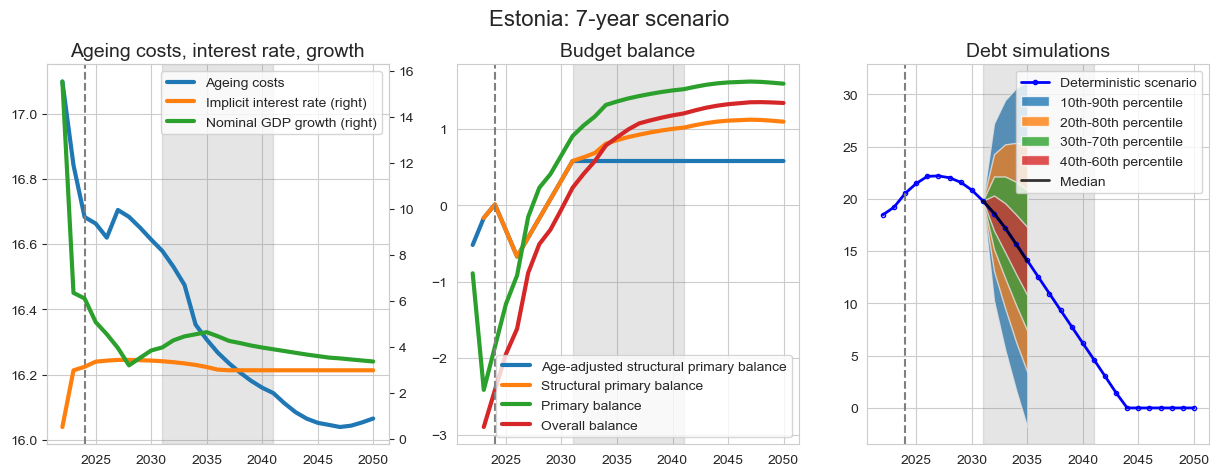

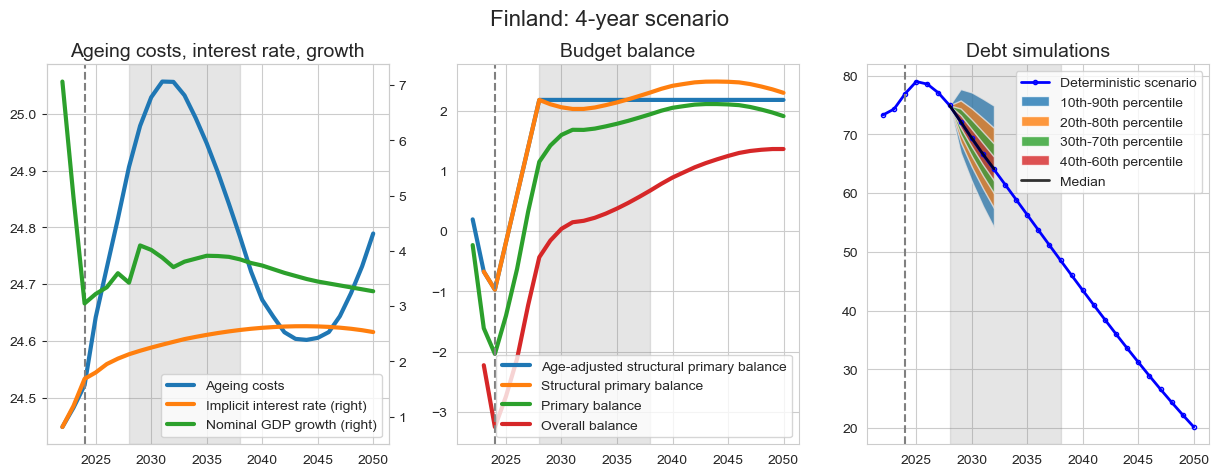

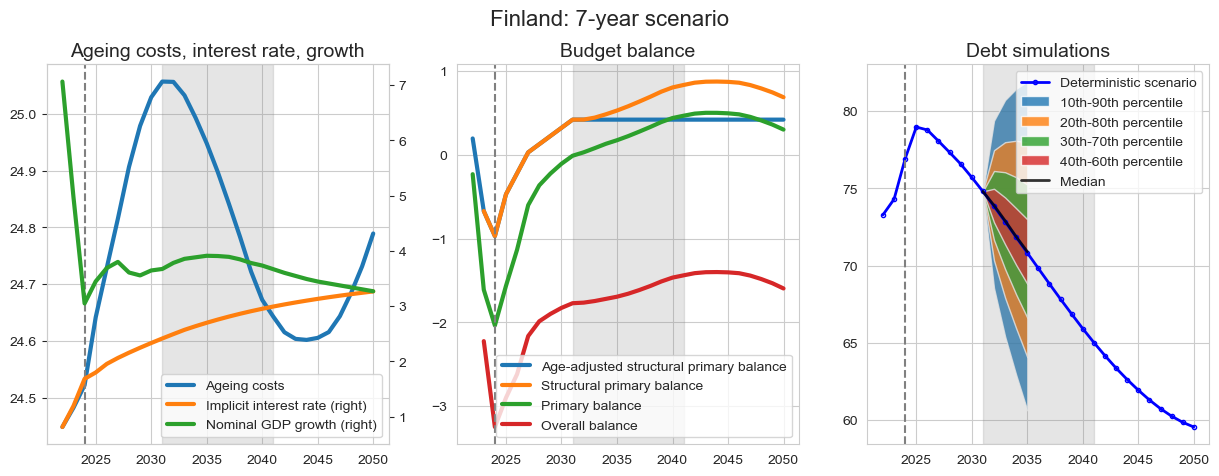

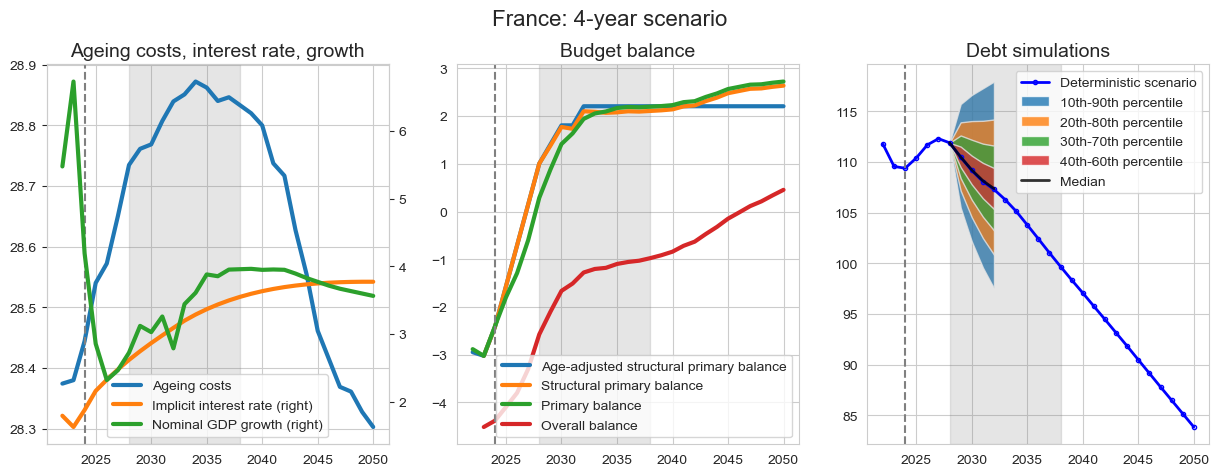

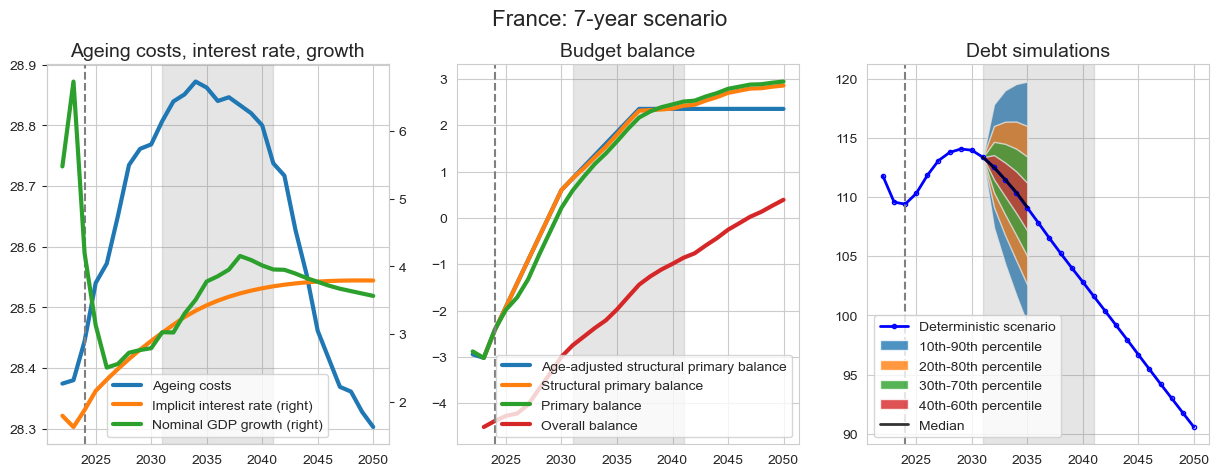

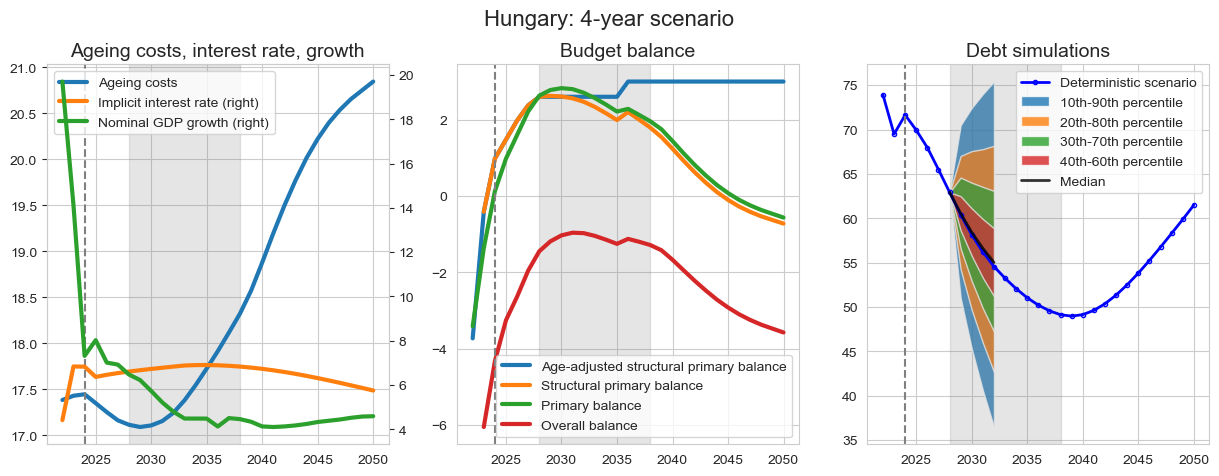

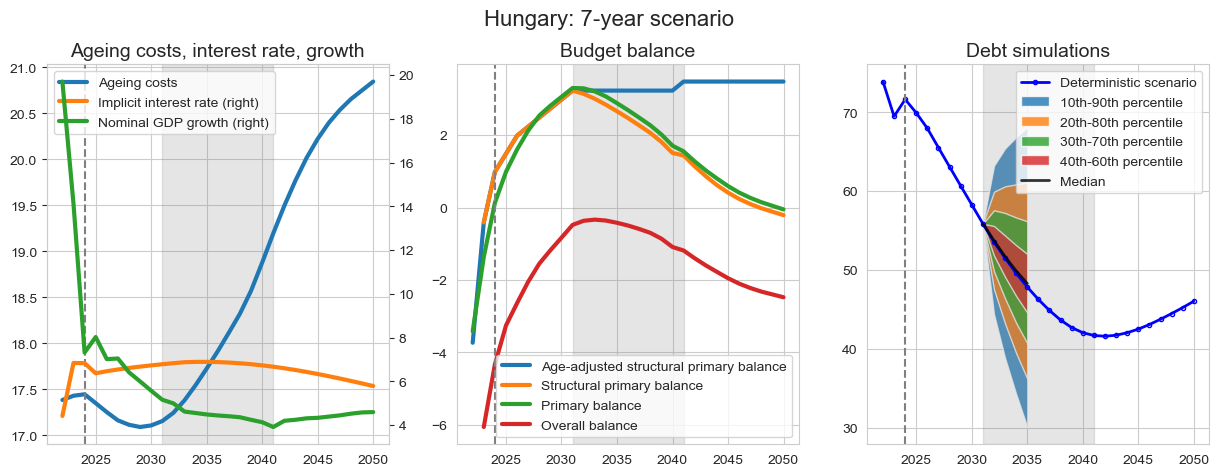

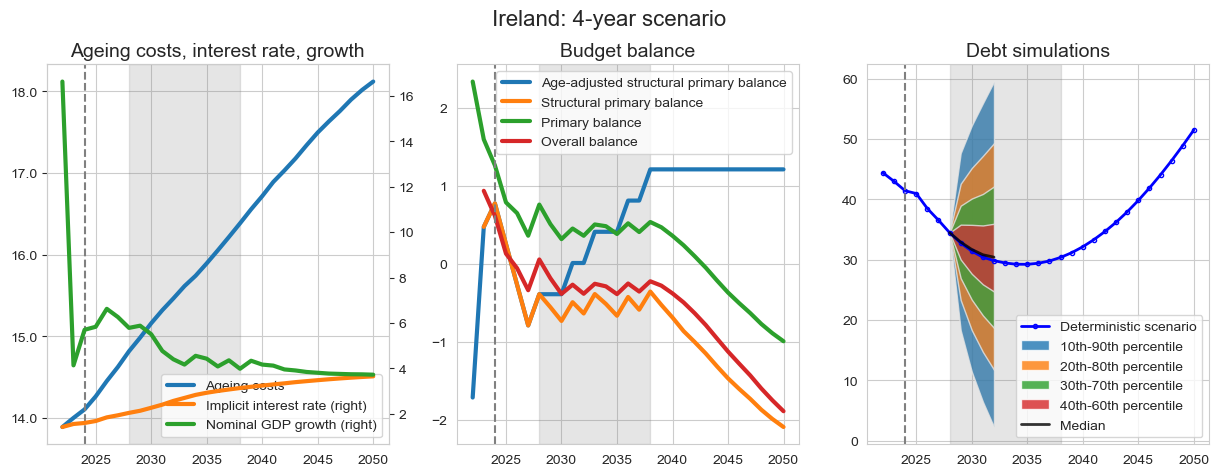

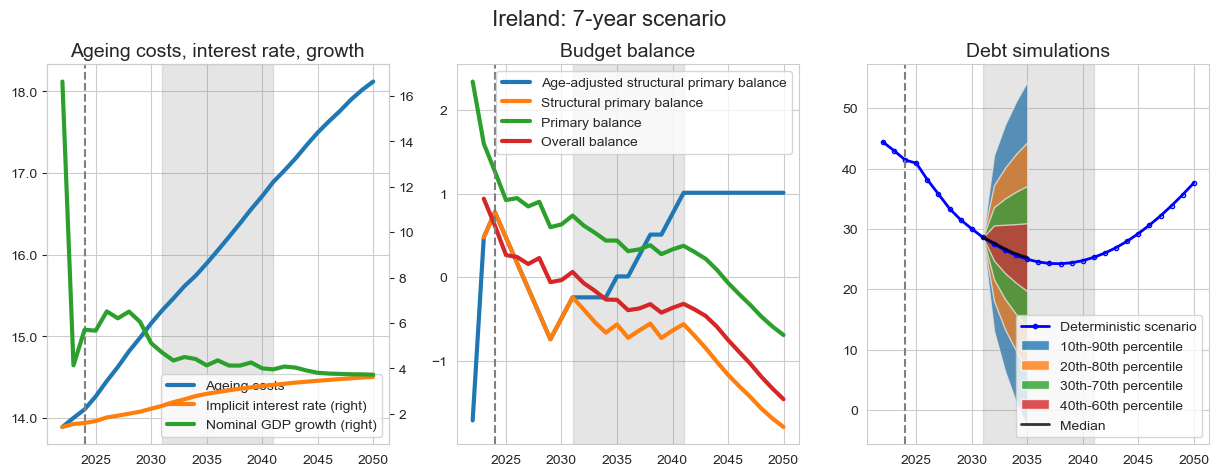

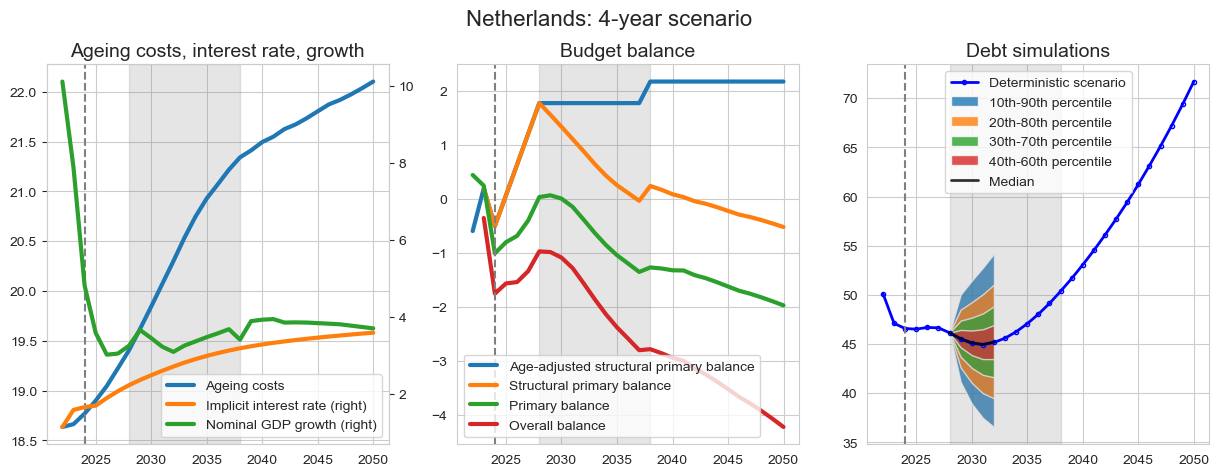

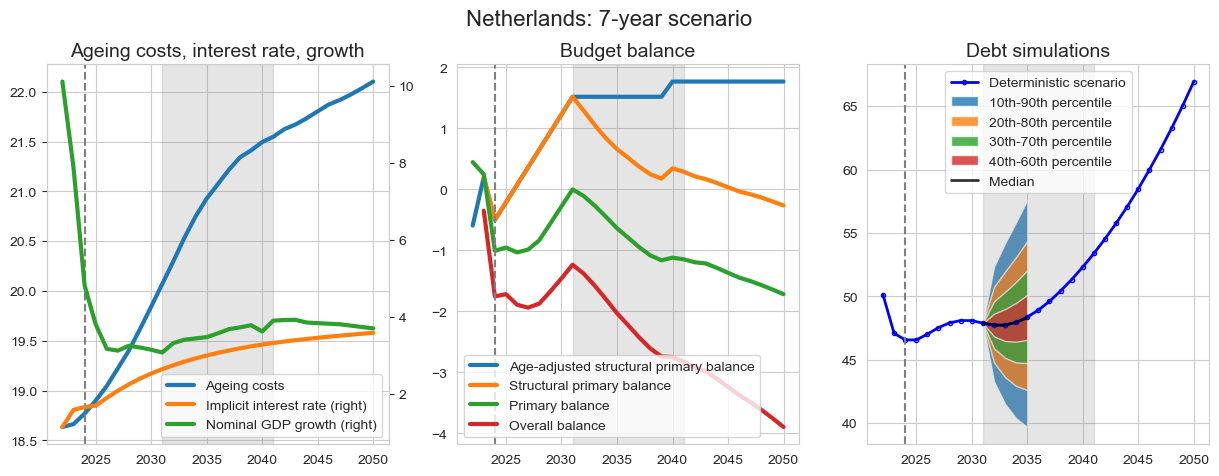

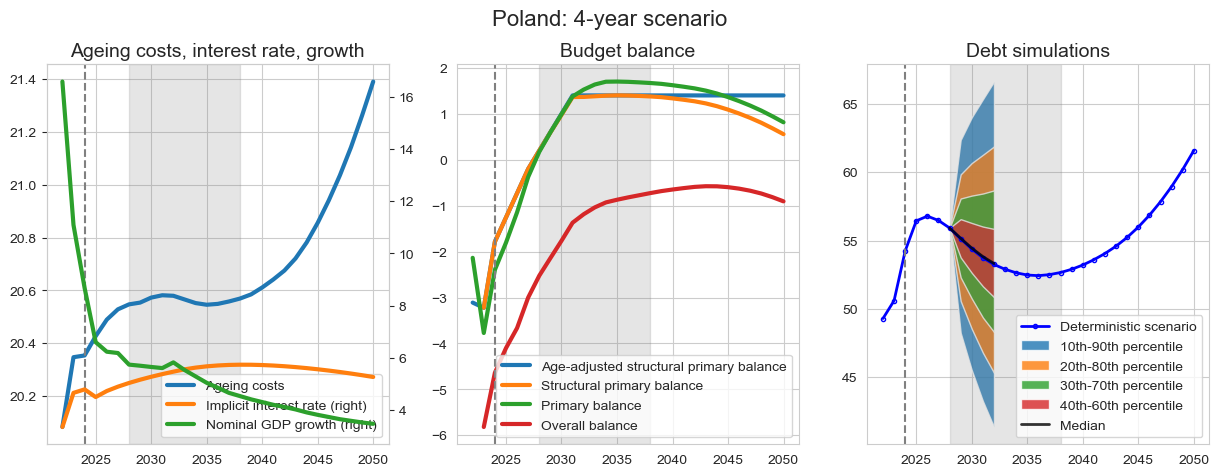

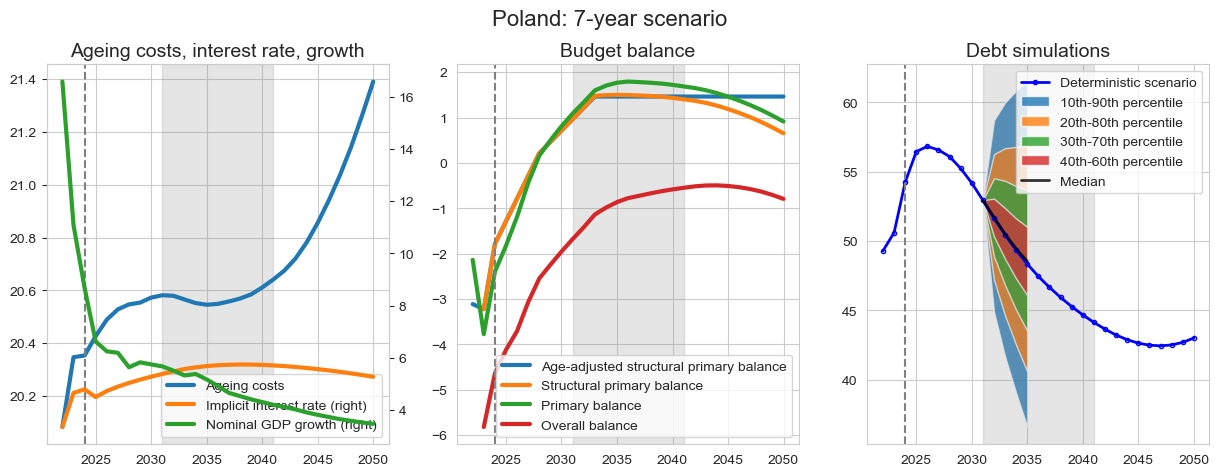

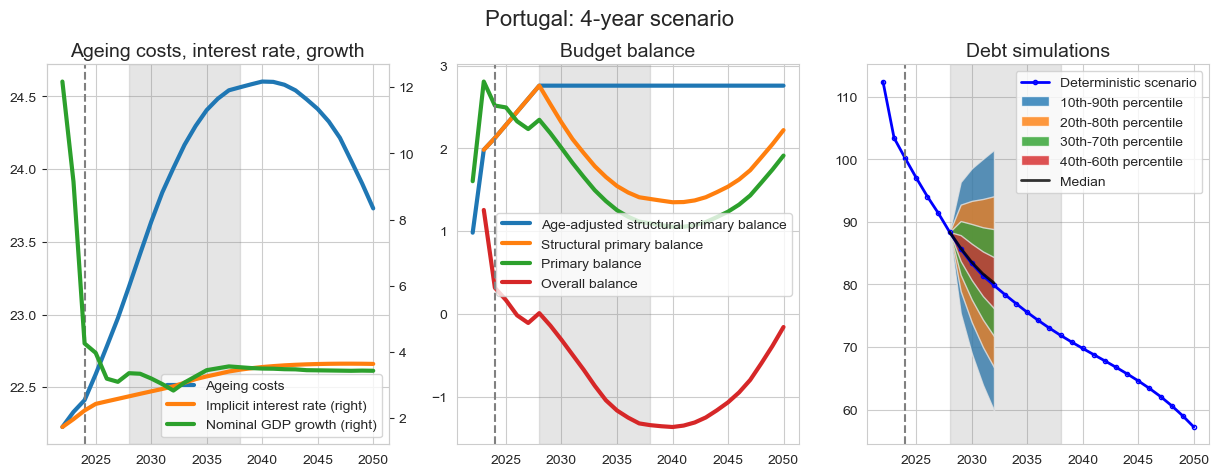

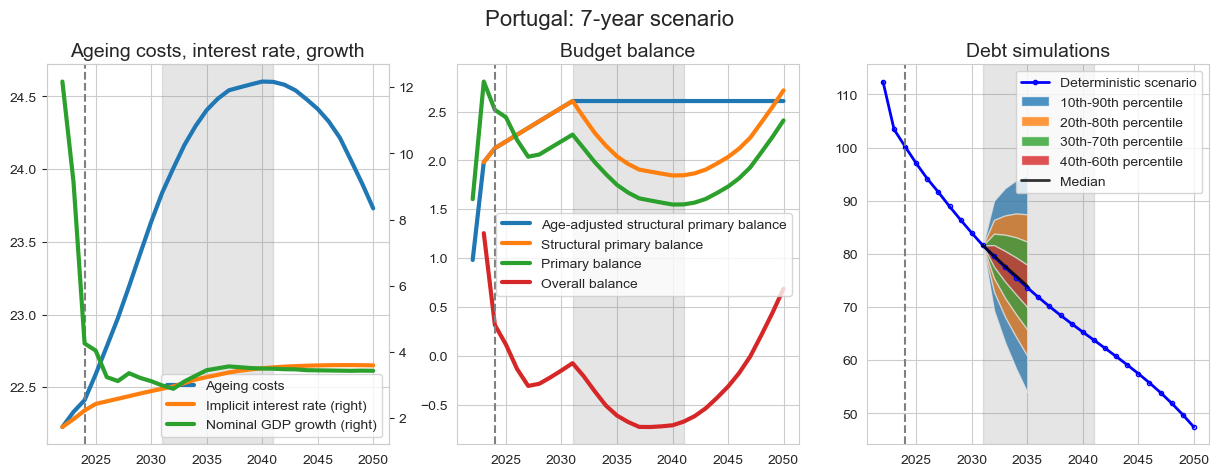

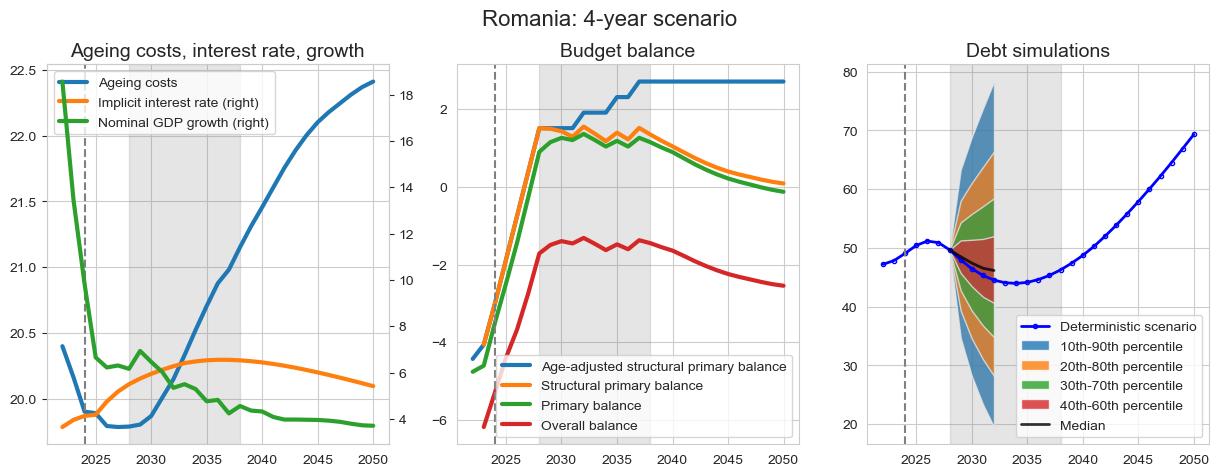

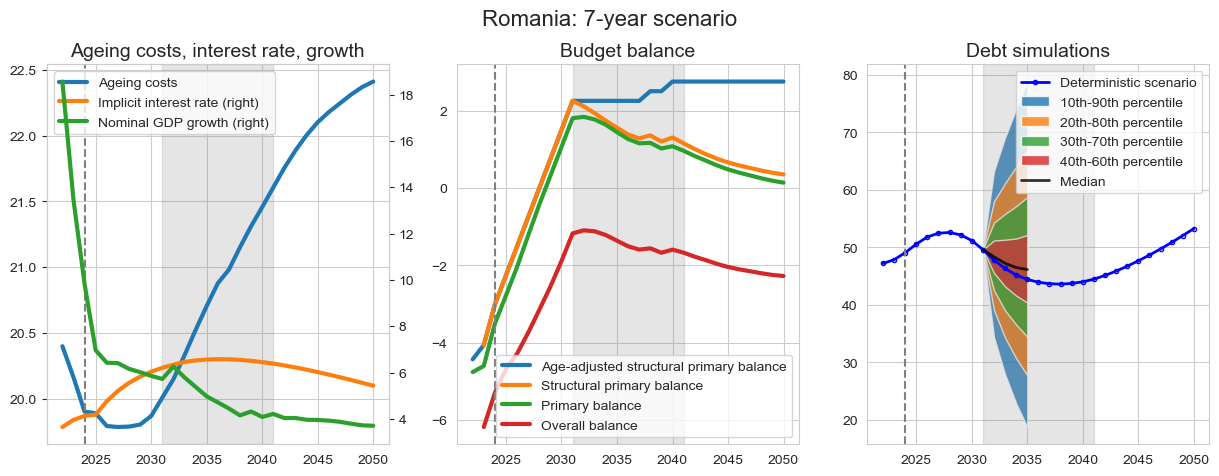

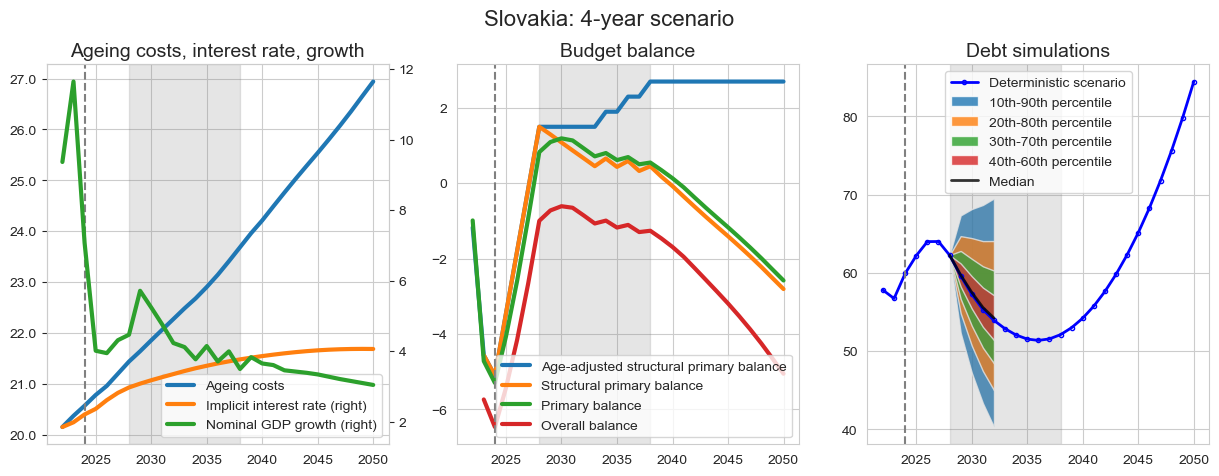

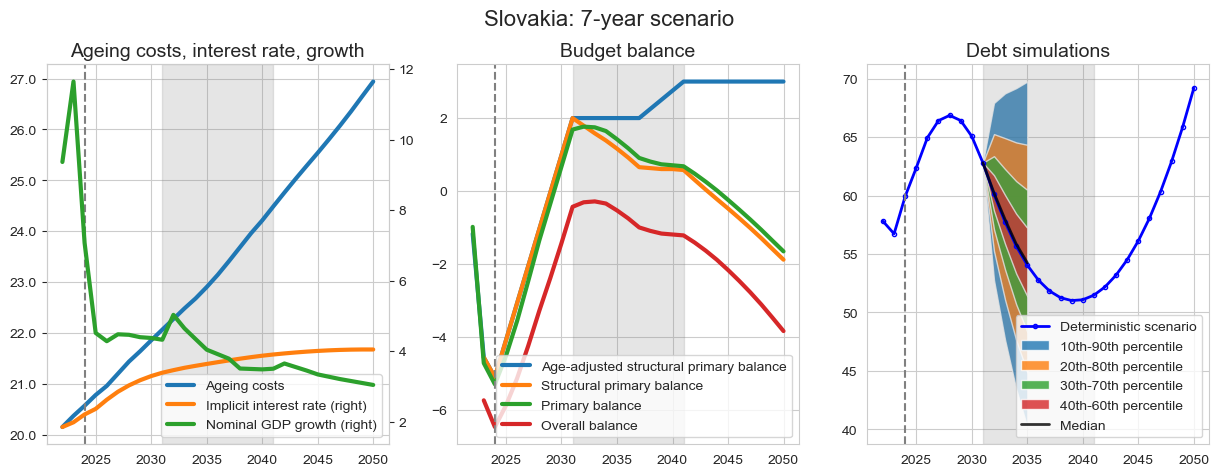

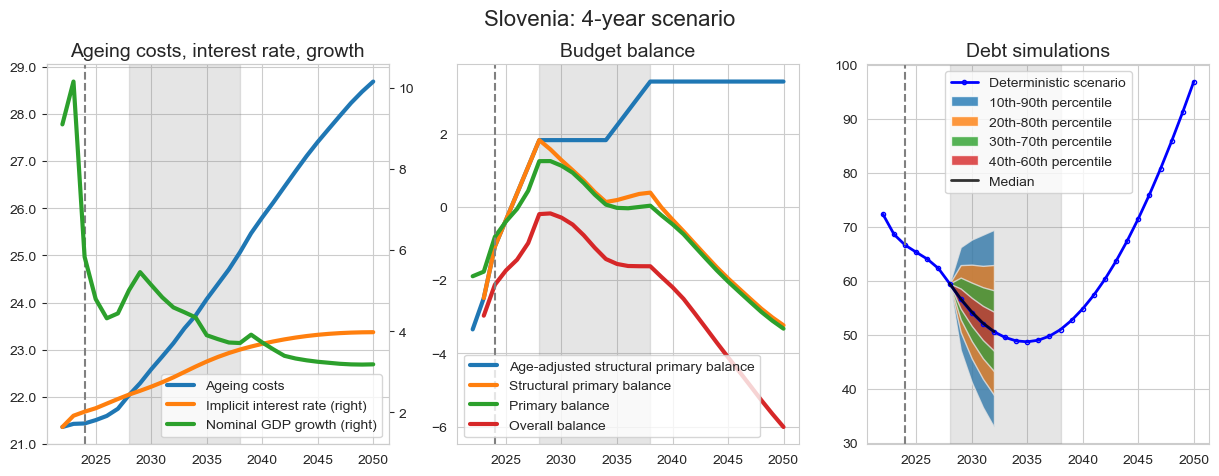

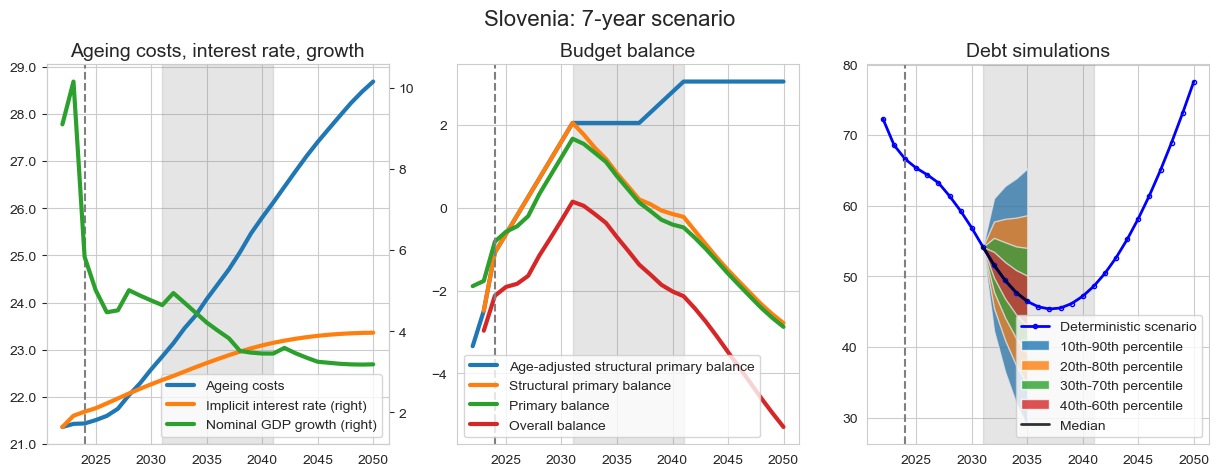

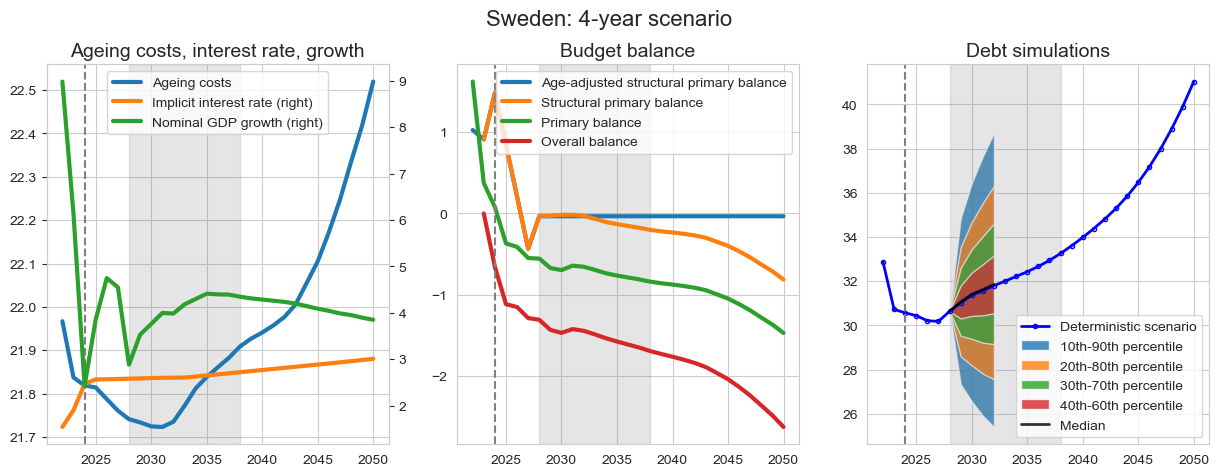

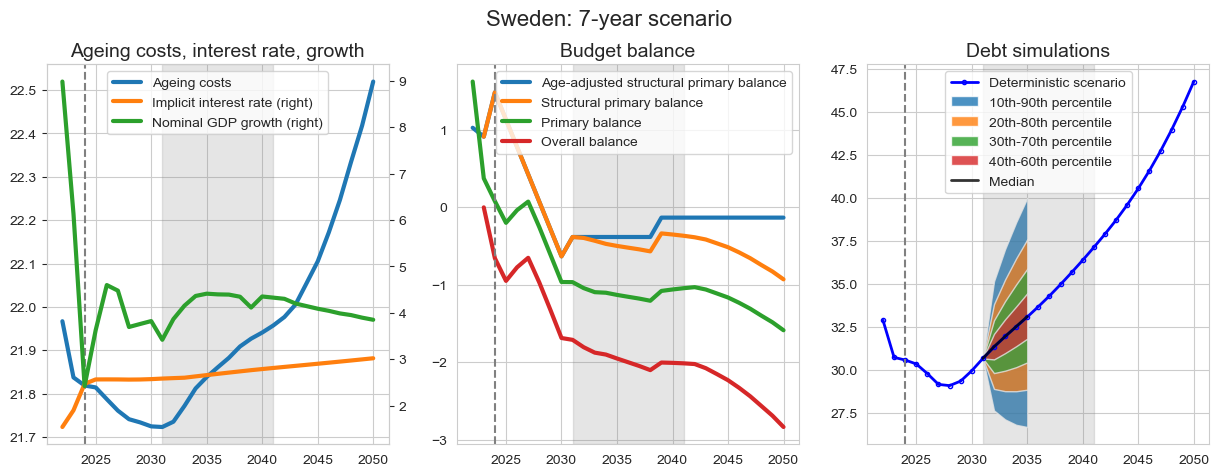

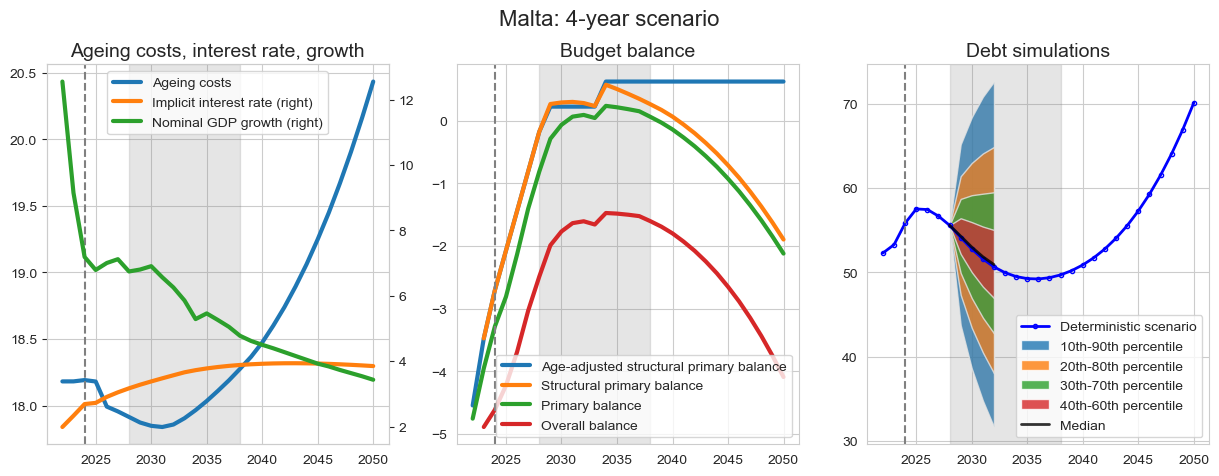

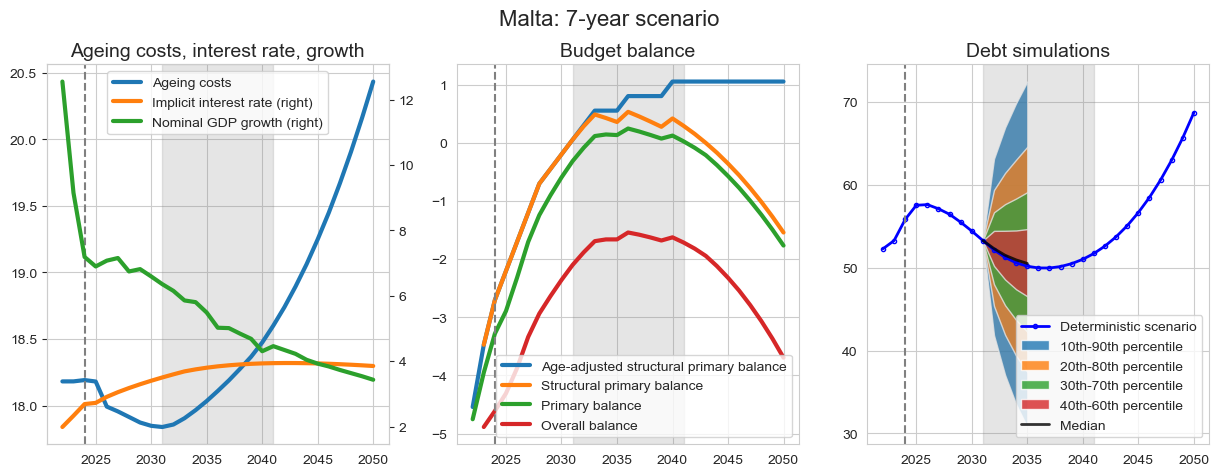

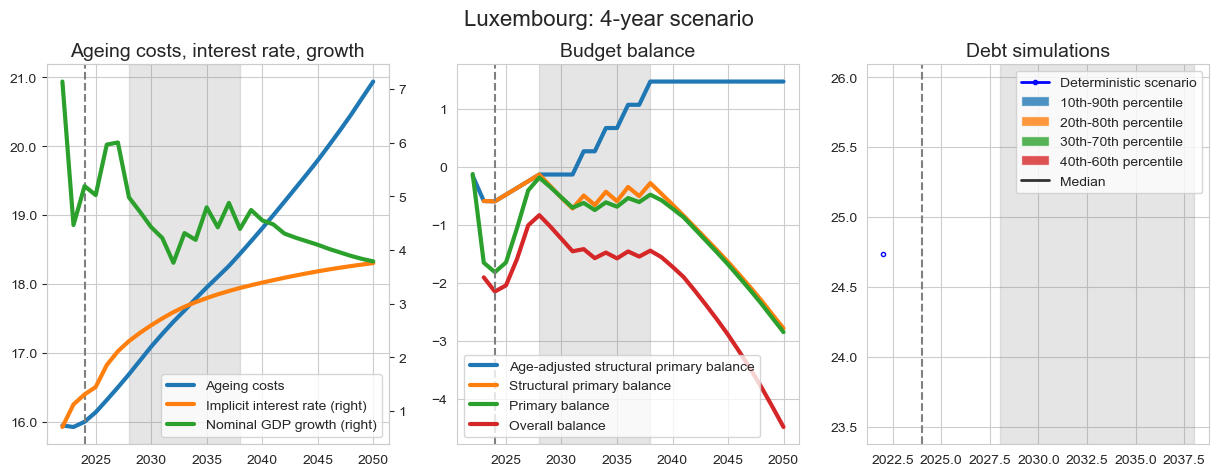

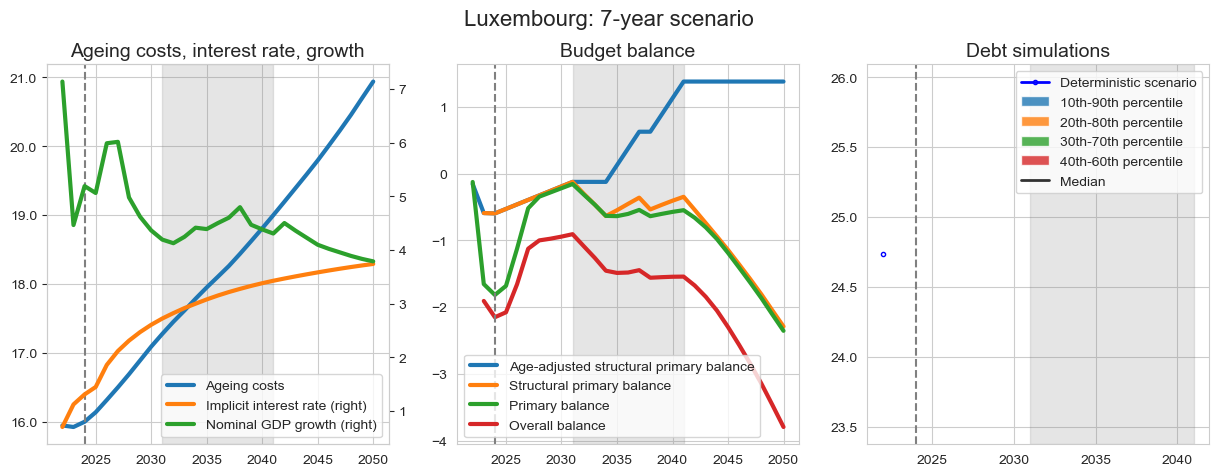

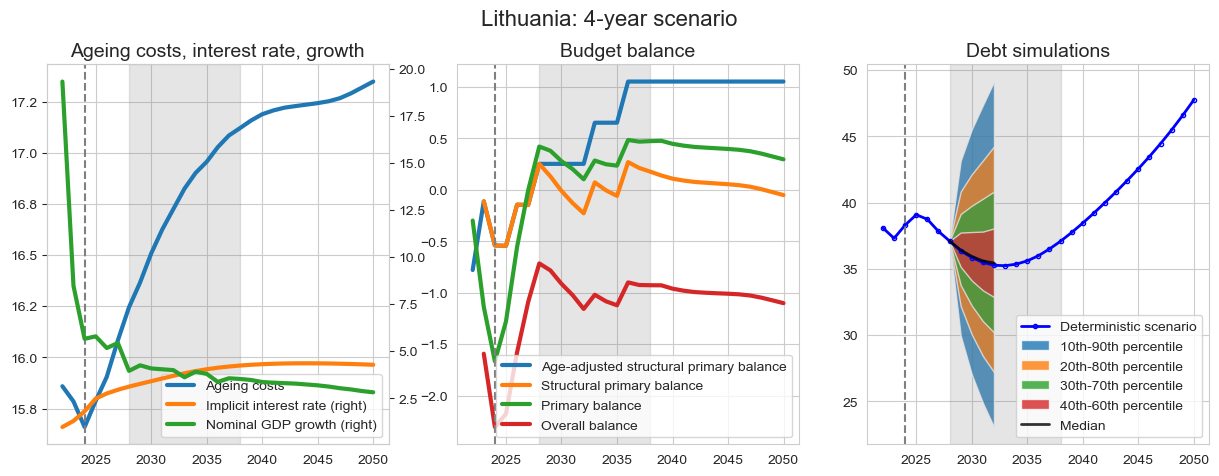

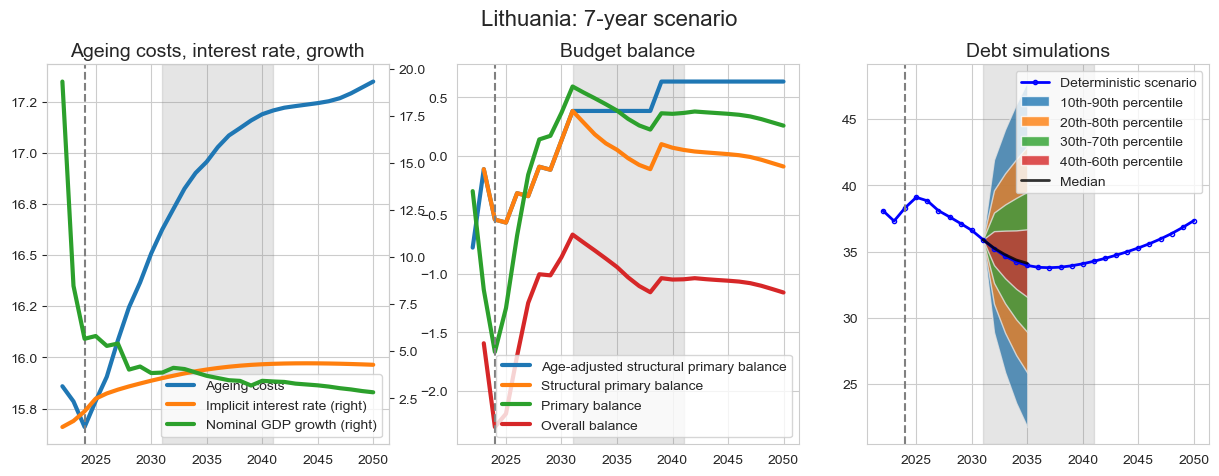

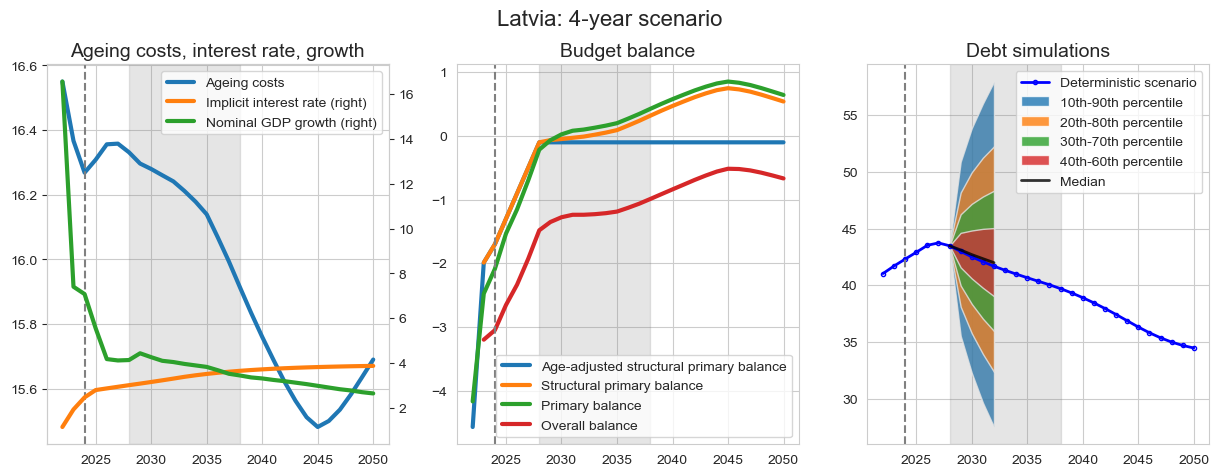

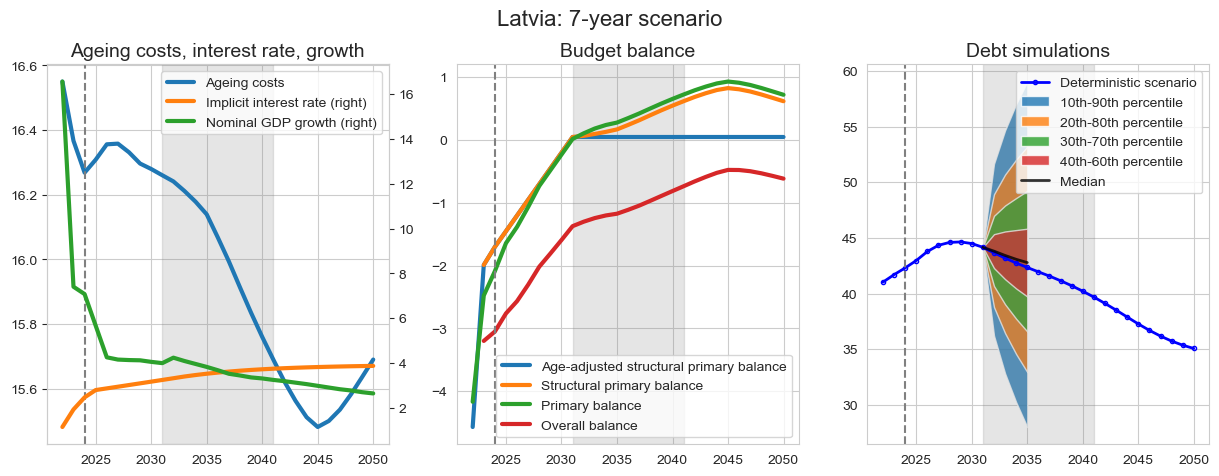

In [42]:
plot_charts(country_code_dict, results_dict, output_path, today)